# Predicting Himalayan Expedition Success - Machine Learning
***


## Introduction

The Himalayan Database ©, consists of records for all expeditions in the Nepal Himalayas from 1905 through 2018. The database covers expeditions to more than 450 significant peaks, including Everest, Cho Oyu and Kangchenjunga. The database is published by The Himalayan Database ©, a non-profit organization. For more information go to http://himalayandatabase.com/index.html.



### Datasets
Three datasets peaks.csv, expeditions.csv and members.csv have already been cleaned and joined into DF_Himalayas_Expeditions.csv for further visual analysis. 

This dataset is now loaded into a DataFrame for statistical analysis.

### Outcome

As a reminder, the data will be used to predict a member's success of a summitting a certain peak, during a certain time of year, with certain support mechanisms.  

## 1. Packages and setup

In [781]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.pylabtools import figsize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Logistic Regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

In [613]:
# Set workspace
pd.set_option('display.max_columns', 500)
# Set output charackters to 110 (not 79)
pd.options.display.width = 110
# To give multiple cell output. Not just the last command.
#InteractiveShell.ast_node_interactivity = 'last'

## 2. Load into DataFrame & Split

In [614]:
# Load data as 'df'
df = pd.read_csv('DF_Himalayas_Expeditions_MLready.csv')
print('Shape:', df.shape)

Shape: (63113, 149)


First extract the required labeled (output) feature and and remove the other output features. 

In [615]:
# Extract the labels feature and drop it from the training data
y = df['msuccess'].values

In [616]:
# Before dropping 'msuccess', first create the heuristic dataframe. More on this later.
df_heuristic = df[['comrte', 'calcage', 'msuccess']]
df.drop('msuccess', inplace=True, axis=1, errors='ignore')

In [617]:
# Reshape
X = np.array(df)
#y = y.reshape(-1, 1)  

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (63113, 148)
y shape:  (63113,)


In [618]:
# Train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

## 3. Machine Learning

As a reminder what we are trying to do; predict the chances of an indivudual successfully summitting a peak in the Himalayas.  

Review different analysis approaches.
- 3.1  Heuristic predictor. This will act as the baseline model at first.
- 3.2  Metrics and scores
- 3.3  Random Forest and Gradient Boost
- 3.4  Logistic Regression
- 3.5  SVM

### 3.1 Heuristic

0    35159
1    27954
Name: comrte, dtype: int64


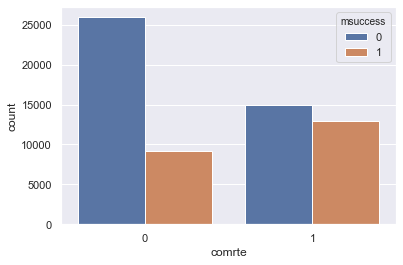

In [619]:
# Explore commercial routes (comrte)
print(df_heuristic.comrte.value_counts())
sns.set()
_ = sns.countplot(x='comrte', hue='msuccess', data=df_heuristic)

It is clear that there is a significant difference between successful summits on commercial routes versus 'off piste' routes. We will use this variable as the heuristic measure of successful summit.

In [751]:
# Integrity check that X[:,37] is infact df['comrte']
sum(df['comrte'].values - X[:,37])

0.0

In [752]:
# Commercial route 'comrte' prediction score on success

h_count = 0
for i in range(len(X_test)):
    if X_test[i,37] == y_test[i]:
        h_count += 1

print('Heuristic score: {:0.2f}'.format(h_count / len(X_test)*100),'%')

# Another way to do it, but quicker? (vectorised)
#(len(y_test) - (X_test[:,37] ^ y_test.reshape(1,-1)).sum()) / len(y_test) * 100

Heuristic score: 60.96 %


Baseline score for 'comrte': 60.96%  
  
A better heuristic feature was later found to be 'o2climb', which gave a score of 74.73%! This will be the heuristic feature that we will use a baseline.  
  
Baseline score to beat ('mo2climb'): 74.73%

### 3.2 Metrics and scores

Below is a function to quickly check the accuracy and ROC score and ROC curve for each model.

In [745]:
def clf_score(clf):
    '''A quick way to call the same function many times to check the clf score'''
    # Check the accuracy on the test set with .predict()
    y_pred = clf.predict(X_test)
    print('Accuracy (.predict): {:0.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
    # Check the accuracy on the test set with .score()
    print('Accuracy   (.score): {:0.4f}'.format(clf.score(X_test, y_test)))
    # Check the  and the ROC score
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    print('ROC score          : {:0.4f}'.format(roc_auc_score(y_test, y_pred_prob)))
    
    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    _ = plt.plot([0, 1], [0, 1], 'k--')
    _ = plt.plot(fpr, tpr, label='Logistic Regression')
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Logistic Regression ROC Curve')
    plt.show();

### 3.3 Random Forest and Gradient Boost

#### 3.3.1 Random Forest

Accuracy (.predict): 0.8378
Accuracy   (.score): 0.8378
ROC score          : 0.9092


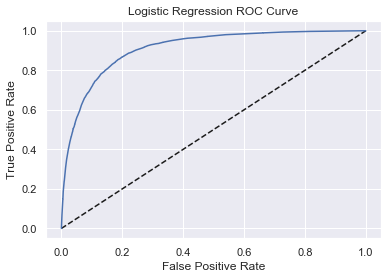

In [746]:
# Initialise Random Forest and fit the training data
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf1.fit(X_train, y_train)
clf_score(clf1)

# Second most accurate, BUT FASTEST!

In [749]:
# Create a DataFrame with the sequence of most important features
feat_imp = pd.DataFrame(zip(df.columns, clf1.feature_importances_), columns=['feature', 'importance']).\
    sort_values(by='importance', ascending=False).head(15)

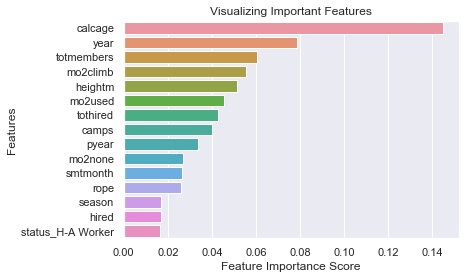

In [750]:
# Plot the most important features
sns.barplot(x='importance', y='feature', data=feat_imp)
# Add labels to your graph
_ = plt.xlabel('Feature Importance Score')
_ = plt.ylabel('Features')
_ = plt.title("Visualizing Important Features")
#_ = plt.legend()
plt.show()

From reviewing the most important features, it is evident that 'comrte' does not even appear in the top 15 best features. A better heuristic will be 'calcage', but the top 3 features are all continous types which will be difficult to predict a yes/no outcome for summit success. An easier heuristic feature to use will be top binary feature, in this case 'mo2climb'.

In [753]:
# Integrity check that X[:,15] is infact df['mo2climb']
sum(df['mo2climb'].values - X[:,15])

0.0

In [754]:
# Oxygen use whilst climbing 'o2climb' prediction score on success

h_count = 0
for i in range(len(X_test)):
    if X_test[i,15] == y_test[i]:
        h_count += 1

print('Heuristic score: {:0.2f}'.format(h_count / len(X_test)*100),'%')

Heuristic score: 74.73 %


Try to further improve the score with cross validation.

In [755]:
scores = cross_val_score(clf1, X, y, cv=5)
scores.mean()

0.6291563910985545

This score is worse than standard Random Forest.  
  
Lets try ExtraTrees Classifier

Accuracy (.predict): 0.8310
Accuracy   (.score): 0.8310
ROC score          : 0.8804


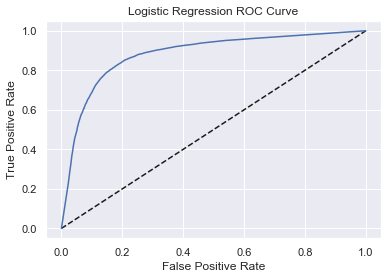

In [757]:
clf2 = ExtraTreesClassifier(n_estimators=100, random_state=42)
clf2.fit(X_train, y_train)
scores = cross_val_score(clf2, X, y, cv=5)
clf_score(clf2)

Still not as good as the standard Random Forest

#### 3.3.2 Gradient Boost

0.5259881045167869
Accuracy (.predict): 0.8427
Accuracy   (.score): 0.8427
ROC score          : 0.9139


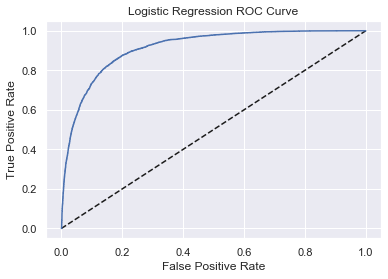

In [759]:
# Gradient Boost Classifier
clf3 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.5, max_depth=10, random_state=42)
clf3.fit(X_train, y_train) 

scores = cross_val_score(clf3, X, y, cv=5)
print(scores.mean())

clf_score(clf3)

# Most accurate, but slowest

0.5975104103319778
Accuracy (.predict): 0.7895
Accuracy   (.score): 0.7895
ROC score          : 0.8599


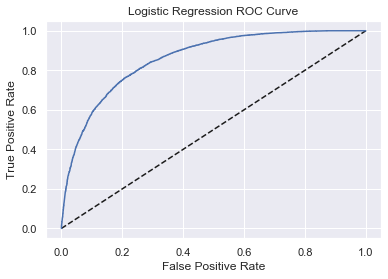

In [758]:
# AdaBoost Clasifier
clf4 = AdaBoostClassifier(n_estimators=100)
clf4.fit(X_train, y_train)
clf_score(clf4)

### 3.3 Logistic Regression

Try KNN and Logistic Regression

KNN:

Accuracy (.predict): 0.7625
Accuracy   (.score): 0.7625
ROC score          : 0.8071


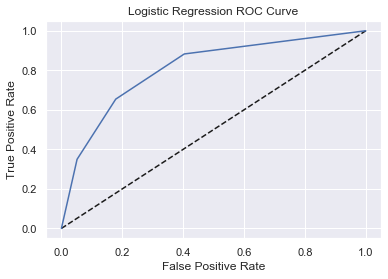

In [760]:
# KNN
clf5 = KNeighborsClassifier(n_neighbors=3)
clf5.fit(X_train, y_train)
clf_score(clf5)

In [780]:
# Grid search for various K's
param_grid = {'n_neighbors': [3, 5, 9, 15]}
clf6 = KNeighborsClassifier()
clf6_cv = GridSearchCV(clf6, param_grid, cv=5)
clf6_cv.fit(X_train, y_train)

# Best parameters
print('Best     K:', clf6_cv.best_params_)
print('Best score: {:0.2f}'.format(clf6_cv.best_score_))

Best     K: {'n_neighbors': 3}
Best score: 0.76


Try KNN with scaling for n_neighbors = 3

Accuracy (.predict): 0.7938
Accuracy   (.score): 0.7938
ROC score          : 0.8439


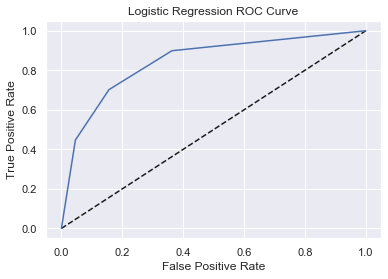

In [782]:
# KNN with scaling in pipeline
steps = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=3))]
pipeline = Pipeline(steps)
clf7 = pipeline.fit(X_train, y_train)

clf_score(clf7)

There is a 4% increase in the score. Try scaling with PCA.

Logistic Regression